In [1]:
from bs4 import BeautifulSoup as BS
import requests
from time import sleep
import numpy as np
import pandas as pd
import re
import pandas as pd
import gzip
import shutil
from datasets import load_dataset
import os
import zipfile
from io import BytesIO
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

/home/lielbin/.conda/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
prefix_path = parent_dir

In [3]:
df_imdb = pd.read_csv(os.path.join(prefix_path, "data/final_data", "tv_imdb_episode_data.csv"))


In [4]:
df_imdb.head()

,tconst_episode,tconst_season,seasonNumber,episodeNumber,title_episode,runtimeMinutes,title_series,averageRating_season,numVotes_series,averageRating_episode,numVotes_episode,Year_episode,sub_id,genres
0,tt0059753,tt0060028,1,0,The Cage,63.0,Star Trek,8.4,95360.0,7.6,7428.0,1966.0,188032.0,"Action,Adventure,Sci-Fi"
1,tt0061027,tt0060028,1,3,Where No Man Has Gone Before,50.0,Star Trek,8.4,95360.0,7.7,6688.0,1966.0,181335.0,"Action,Adventure,Sci-Fi"
2,tt0066931,tt1466074,1,3,Dead Weight,76.0,Columbo,8.3,43873.0,6.9,3538.0,1971.0,94598.0,"Crime,Drama,Mystery"
3,tt0073677,tt0071054,3,17,The Secret of Bigfoot: Part 1,47.0,The Six Million Dollar Man,7.1,13511.0,7.6,399.0,1976.0,297110.0,"Action,Crime,Drama"
4,tt0084218,tt0083437,1,1,Knight of the Phoenix: Part 1,45.0,Knight Rider,6.9,38628.0,7.3,2272.0,1982.0,5919.0,"Action,Crime,Drama"


In [5]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34673 entries, 0 to 34672
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tconst_episode         34673 non-null  object 
 1   tconst_season          34673 non-null  object 
 2   seasonNumber           34673 non-null  int64  
 3   episodeNumber          34673 non-null  int64  
 4   title_episode          34673 non-null  object 
 5   runtimeMinutes         34673 non-null  float64
 6   title_series           34673 non-null  object 
 7   averageRating_season   34673 non-null  float64
 8   numVotes_series        34673 non-null  float64
 9   averageRating_episode  34673 non-null  float64
 10  numVotes_episode       34673 non-null  float64
 11  Year_episode           34673 non-null  float64
 12  sub_id                 34673 non-null  float64
 13  genres                 34673 non-null  object 
dtypes: float64(7), int64(2), object(5)
memory usage: 3.7+ 

In [6]:
df_subid_subtitles = pd.read_csv(os.path.join(prefix_path, "data/final_data", "subid_subtitles.csv"))


In [7]:
df_subid_subtitles.head()

,sub_id,subtitles
0,188032.0,"הכלוב .תבדקו את המעגל- .הכול תקין, אדוני- .אם ..."
1,181335.0,",יומן הקפטן .זמן כוכבים 1312.4 ,הבלתי אפשרי קר..."
2,94598.0,.דוטון .גנרל הוליסטר .היכנס ?רוצה לשתות- .לא. ...
3,297110.0,***האיש השווה מיליונים*** תורגם סונכרן וקודד ע...
4,5919.0,"<i>- קונסוליה זרה, ארה""ב -</i> ?תסלחי לי לרגע ..."


In [8]:
df_subid_subtitles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34673 entries, 0 to 34672
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sub_id     34673 non-null  float64
 1   subtitles  34673 non-null  object 
dtypes: float64(1), object(1)
memory usage: 541.9+ KB


In [29]:
df_summarized_subtitles = pd.read_csv(os.path.join(prefix_path, "data/final_data", "summarized_subtitles.csv"))


In [30]:
df_summarized_subtitles.head()

,sub_id,full_summary,combined_embedding
0,188032,"[/INST]הספינה נתקלה באות מצוקה ישן, שנראה שמקו...","-1.188,-1.165,-0.635,1.221,-0.2505,-0.4976,-0...."
1,181335,"[/INST]\nהקפטן של ספינת החלל אנטרפרייז, ג'יימס...","-1.007,-1.57,0.064,1.624,0.01962,0.5225,-0.307..."
2,94598,[/INST]\nהגנרל הוליסטר מגיע לפגישה עם קולונל ד...,"-0.785,-1.588,-0.7036,0.8857,-0.783,-0.18,-0.2..."
3,297110,"[/INST]סטיב אוסטין, אסטרונאוט לשעבר, הוא האדם ...","-0.185,-2.111,-0.05966,1.003,-0.6733,0.2983,-0..."
4,5919,"[/INST]בסיפור, קבוצת אנשים, כולל מייקל, שרה, ...","-1.584,-1.215,-0.5728,1.715,-0.7676,-1.019,1.2..."


In [31]:
df_summarized_subtitles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34673 entries, 0 to 34672
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sub_id              34673 non-null  int64 
 1   full_summary        34673 non-null  object
 2   combined_embedding  34673 non-null  object
dtypes: int64(1), object(2)
memory usage: 812.8+ KB


In [39]:
# Convert the first record's embedding string into a NumPy array
first_embedding = np.fromstring(df_summarized_subtitles["combined_embedding"].iloc[342], sep=",")

# Print the shape of the first embedding
print(first_embedding.shape)

(4096,)


In [12]:
# Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats  # This ensures we're using scipy.stats

%matplotlib inline

In [21]:
def analyze_rating_distribution(df):
    # Ensure 'averageRating_episode' does not contain NaN values
    df = df.dropna(subset=['averageRating_episode'])
    
    plt.figure(figsize=(15, 10))  # Set overall figure size
    
    # Subplot 1: Histogram with KDE
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='averageRating_episode', bins=30, kde=True, color='skyblue')
    plt.title('Distribution of Episode Ratings')
    plt.xlabel('Average Rating')
    plt.ylabel('Count')
    plt.grid(True)
    
    # Subplot 2: Box Plot
    plt.subplot(2, 2, 2)
    sns.boxplot(y=df['averageRating_episode'], color='lightgreen')
    plt.title('Box Plot of Episode Ratings')
    plt.ylabel('Average Rating')
    plt.grid(True, axis='y')
    
    # Subplot 3: Q-Q Plot
    plt.subplot(2, 2, 3)
    stats.probplot(df['averageRating_episode'], dist="norm", plot=plt)  # Ensure scipy.stats is used
    plt.title('Q-Q Plot (Normality Test)')
    
    # Subplot 4: Violin Plot
    plt.subplot(2, 2, 4)
    sns.violinplot(y=df['averageRating_episode'], color='lightcoral')
    plt.title('Violin Plot of Episode Ratings')
    plt.ylabel('Average Rating')
    plt.grid(True, axis='y')
    
    # Adjust subplot layout
    plt.tight_layout()
    
    # Calculate distribution statistics
    stats_dict = {
        'Count': len(df),
        'Mean': df['averageRating_episode'].mean(),
        'Median': df['averageRating_episode'].median(),
        'Std Dev': df['averageRating_episode'].std(),
        'Skewness': df['averageRating_episode'].skew(),
        'Kurtosis': df['averageRating_episode'].kurtosis(),
        'Min': df['averageRating_episode'].min(),
        'Max': df['averageRating_episode'].max()
    }
    
    # Print statistics
    print("\nDistribution Statistics:")
    for key, value in stats_dict.items():
        print(f"{key}: {value:.3f}")
    
    # Calculate percentiles
    percentiles = [0, 10, 25, 50, 75, 90, 100]
    print("\nPercentile Distribution:")
    for p in percentiles:
        value = np.percentile(df['averageRating_episode'], p)
        print(f"{p}th percentile: {value:.3f}")
    
    # Check for rating ranges distribution 
    bins = pd.cut(
        df['averageRating_episode'], 
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
        labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10']
    )
    
    # Calculate distribution
    range_dist = bins.value_counts().sort_index()
    
    # Print results
    print("\nRating Ranges Distribution:")
    print(range_dist)
    
    print("\nPercentage Distribution:")
    print((range_dist / len(df) * 100).round(2))


    return stats_dict, range_dist



Distribution Statistics:
Count: 34673.000
Mean: 7.638
Median: 7.700
Std Dev: 0.730
Skewness: -0.728
Kurtosis: 2.843
Min: 1.600
Max: 10.000

Percentile Distribution:
0th percentile: 1.600
10th percentile: 6.800
25th percentile: 7.200
50th percentile: 7.700
75th percentile: 8.100
90th percentile: 8.500
100th percentile: 10.000

Rating Ranges Distribution:
averageRating_episode
0-1         0
1-2         2
2-3         3
3-4        49
4-5       139
5-6       648
6-7      5023
7-8     19493
8-9      8588
9-10      728
Name: count, dtype: int64

Percentage Distribution:
averageRating_episode
0-1      0.00
1-2      0.01
2-3      0.01
3-4      0.14
4-5      0.40
5-6      1.87
6-7     14.49
7-8     56.22
8-9     24.77
9-10     2.10
Name: count, dtype: float64


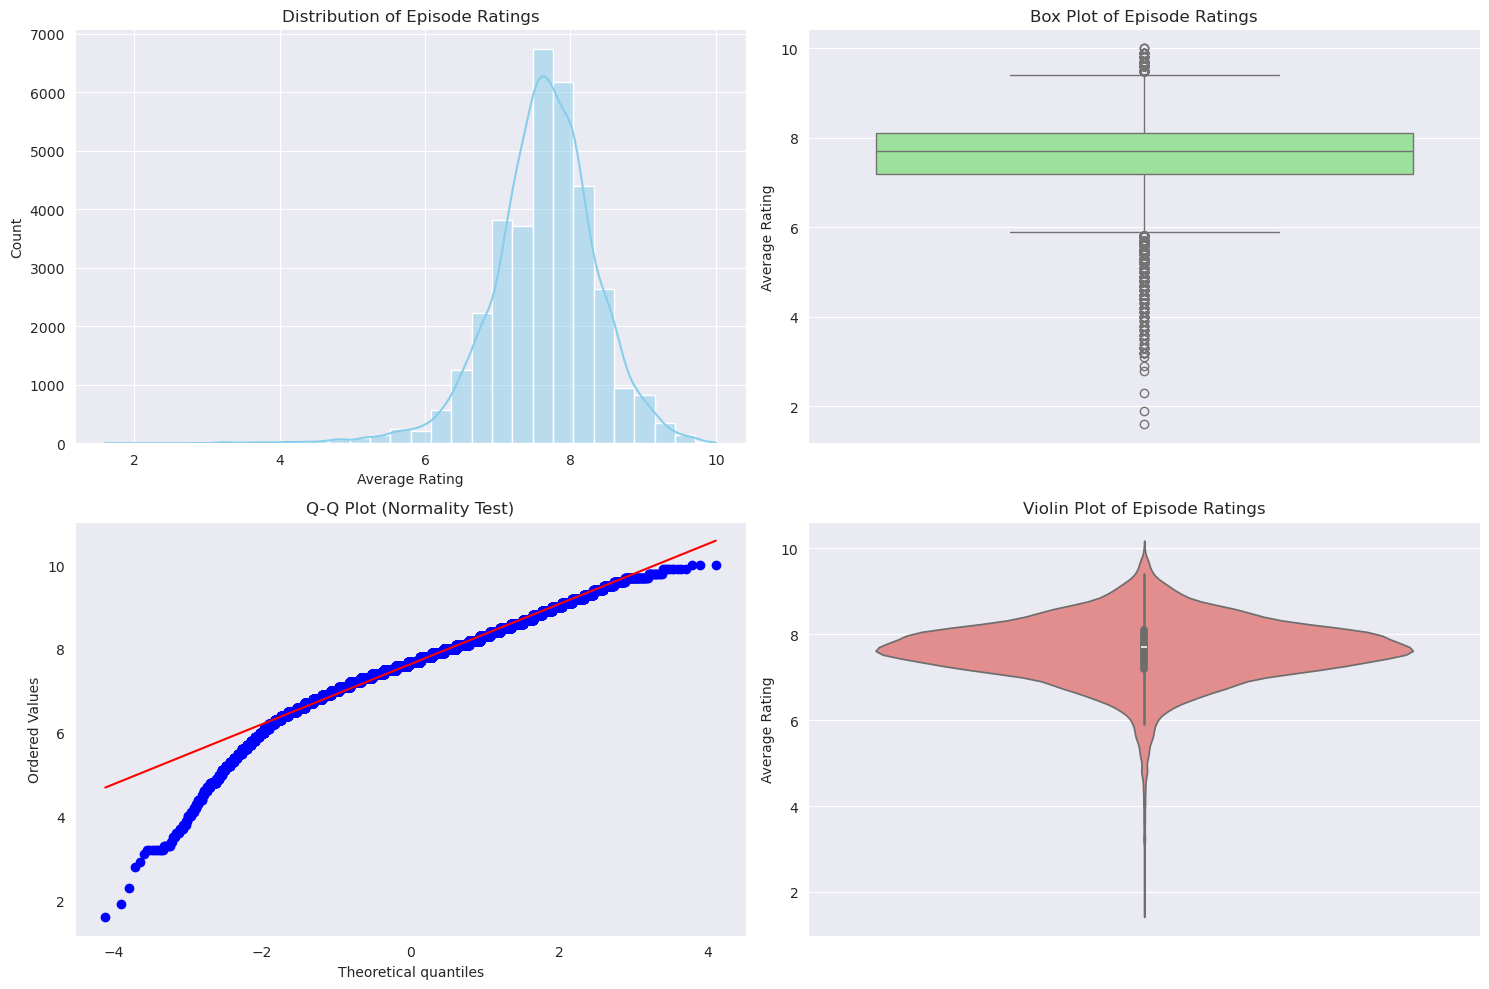

In [23]:
# Call the function
# Correct variable names to avoid conflict
distribution_stats, rating_ranges = analyze_rating_distribution(df_imdb)


In [24]:
df_imdb.describe().T.drop("count",axis=1)


,mean,std,min,25%,50%,75%,max
seasonNumber,3.028552,3.240253,1.0,1.000000,2.0,4.0,37.0
episodeNumber,8.042685,6.139075,0.0,3.000000,6.0,11.0,64.0
runtimeMinutes,39.441956,13.317944,2.0,27.607143,42.0,45.0,251.0
averageRating_season,7.551230,0.885593,2.0,7.000000,7.6,8.2,9.5
numVotes_series,107528.873562,189200.054928,22.0,8591.000000,37553.0,131778.0,2373814.0
averageRating_episode,7.638330,0.729868,1.6,7.200000,7.7,8.1,10.0
numVotes_episode,1313.022611,3316.773253,5.0,150.000000,451.0,1291.0,228263.0
Year_episode,2011.011219,11.228457,1955.0,2005.000000,2010.0,2021.0,2024.0
sub_id,229349.321114,89123.556200,21.0,184891.000000,258684.0,293143.0,337605.0


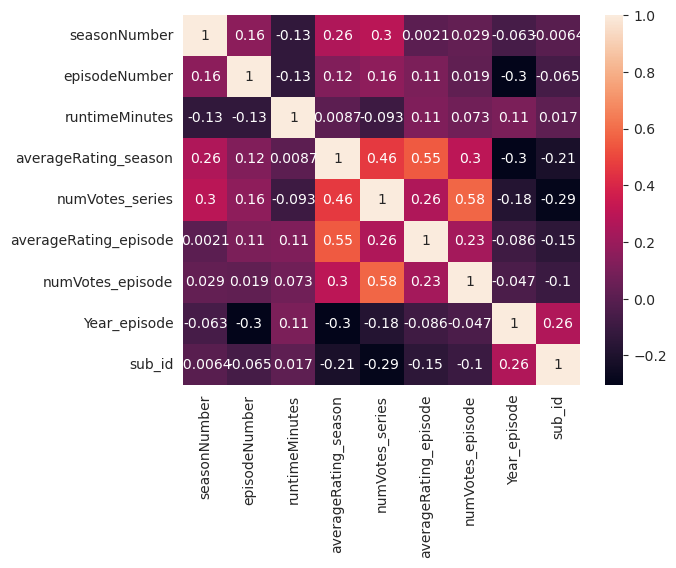

In [25]:
numerical_df = df_imdb.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [26]:
ratings=df_imdb.sort_values(['numVotes_episode'],ascending=False)
imdb=df_imdb.sort_values(['averageRating_episode'],ascending=False)

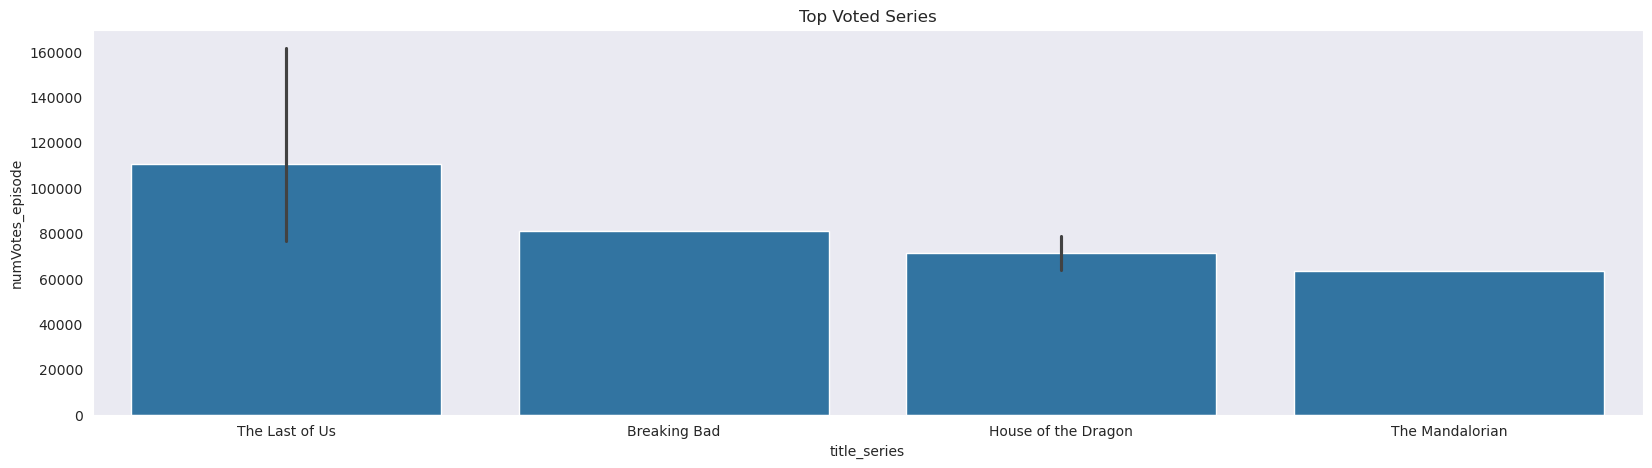

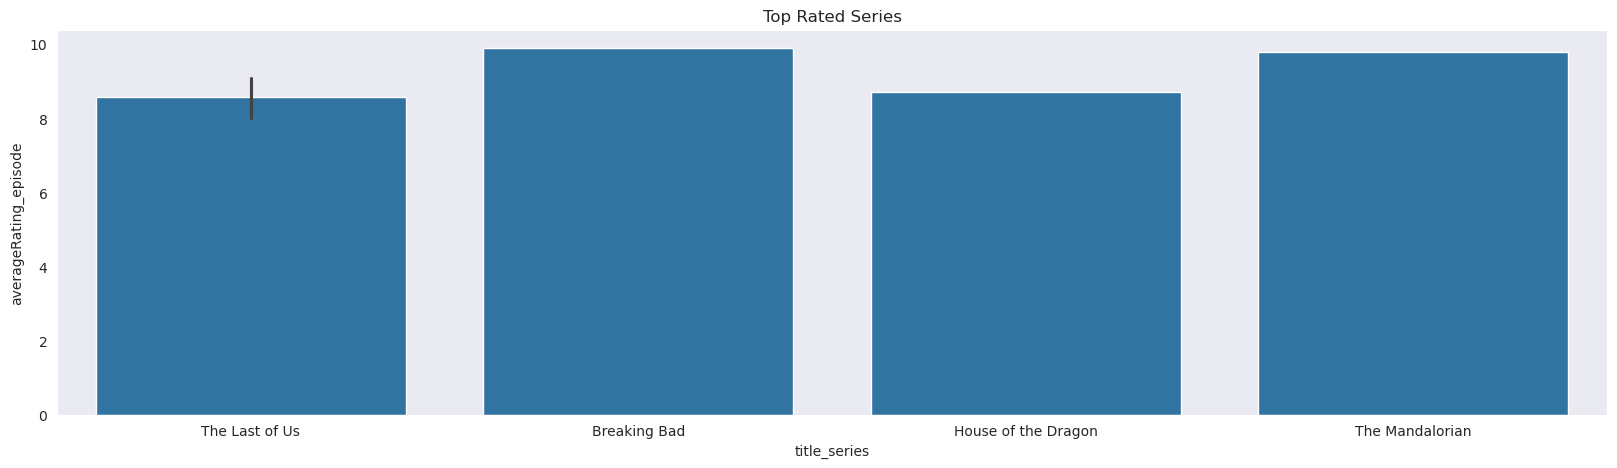

<Figure size 640x480 with 0 Axes>

In [27]:
fig,axs=plt.subplots(figsize=(20,5))
g=sns.barplot(x=ratings['title_series'][:10],y=ratings['numVotes_episode'][:10])
g.set_title("Top Voted Series")
plt.show()
fig,axs=plt.subplots(figsize=(20,5))
g=sns.barplot(x=ratings['title_series'][:10],y=ratings['averageRating_episode'][:10])
g.set_title("Top Rated Series")
plt.show()
plt.tight_layout()

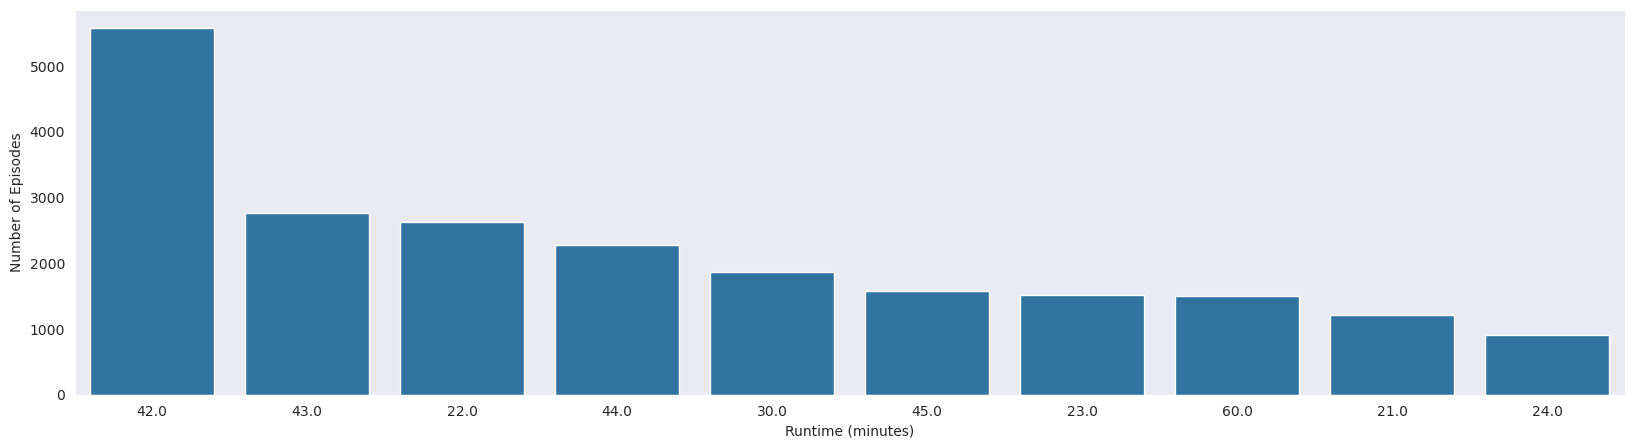

In [28]:
run_inmin=df_imdb['runtimeMinutes'].apply(lambda x:str(x).split(" ")[0])
fig,axs=plt.subplots(figsize=(20,5))
g=sns.barplot(x=run_inmin.value_counts()[:10].index,y=run_inmin.value_counts()[:10])
g.set_xlabel("Runtime (minutes)")
g.set_ylabel("Number of Episodes")
plt.show()

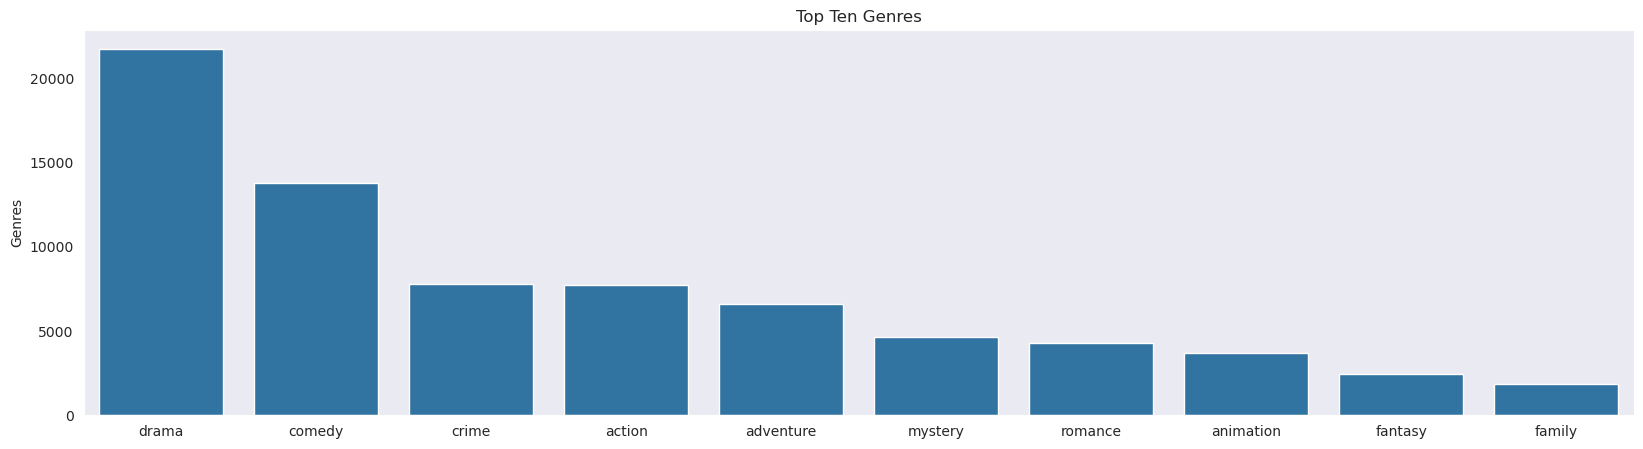

In [29]:
genre=[]
for x in df_imdb['genres']:
    for y in x.split(','):
        genre.append(y.strip().lower())
# Finding the Count of these Genres
count=Counter(genre)
count=count.most_common()[:10]
x,y=map(list,zip(*count))
# Assuming x and y are your data
fig, axs = plt.subplots(figsize=(20,5))
g = sns.barplot(x=x, y=y)  # Use keyword arguments 'x=' and 'y='
g.set_ylabel("Genres")
g.set_title("Top Ten Genres")
plt.show()

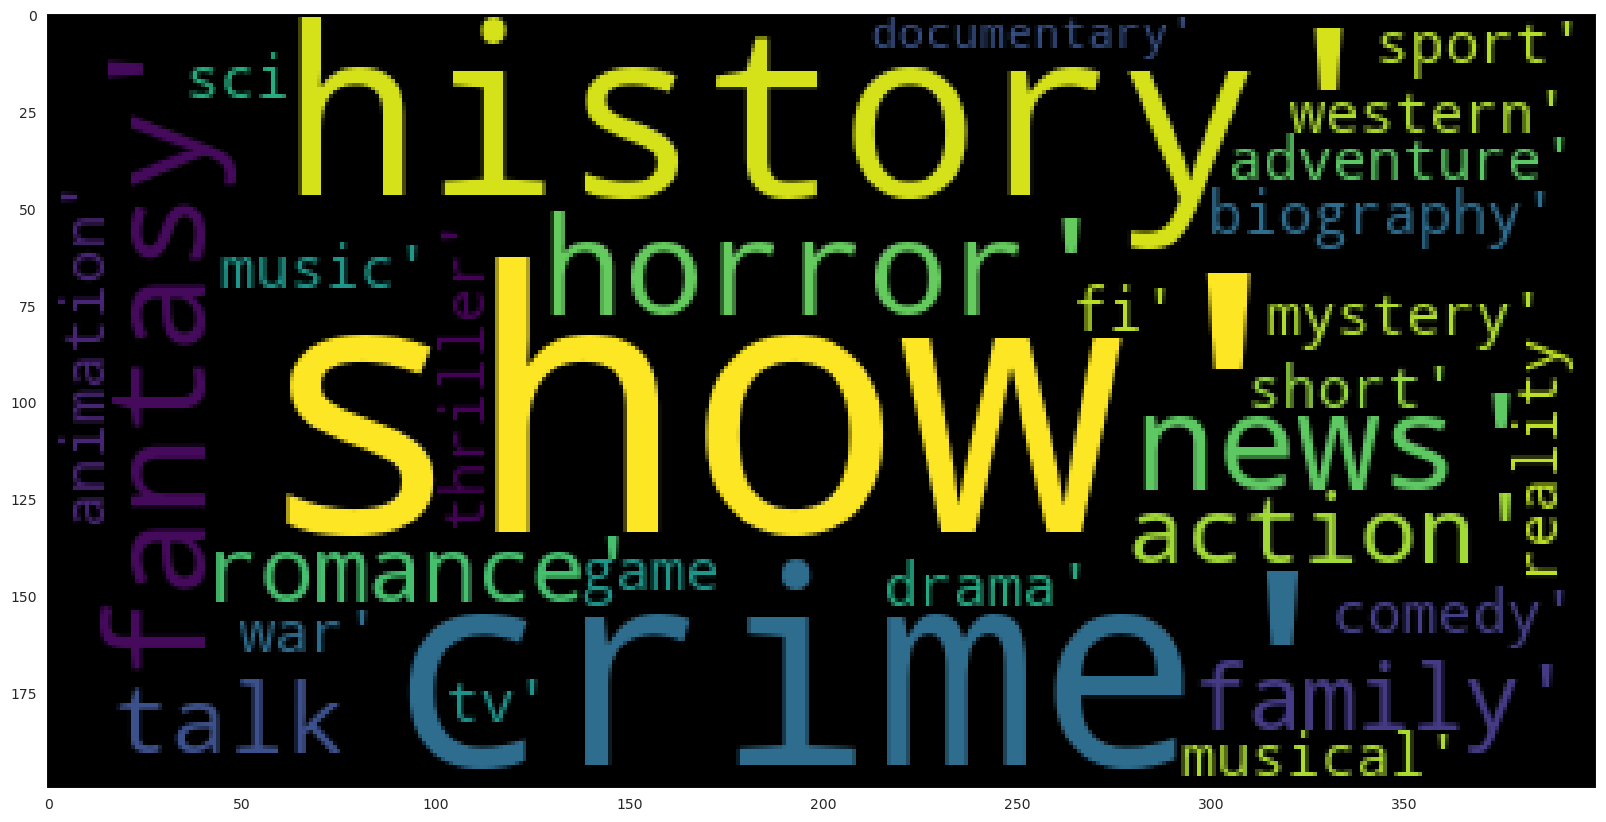

In [30]:
from wordcloud import WordCloud
text=set(genre)
wordc=WordCloud(max_words=1500,background_color='black').generate(str(text))
fig,axs=plt.subplots(figsize=(20,20))
sns.set_style('dark')
plt.imshow(wordc)

/tmp/ipykernel_2092074/936671348.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g=sns.distplot(df_imdb['averageRating_episode'],bins=30)


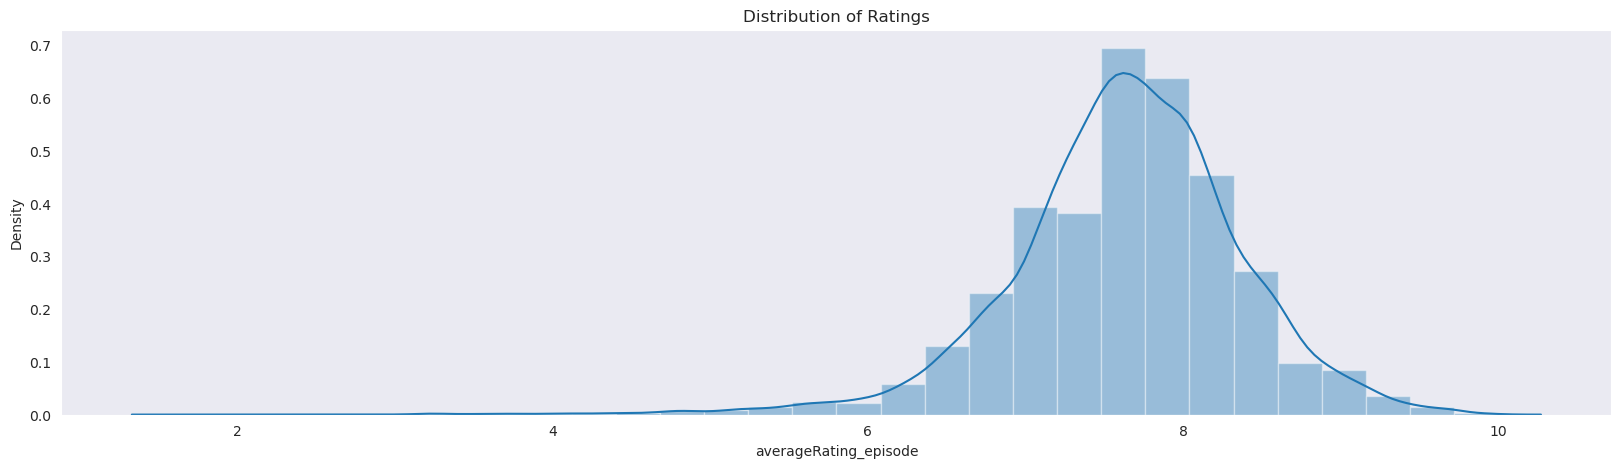

In [31]:
fig,axs=plt.subplots(figsize=(20,5))
g=sns.distplot(df_imdb['averageRating_episode'],bins=30)
g.set_title("Distribution of Ratings")
plt.show()

In [13]:
# Leaky - contains rating information
df_imdb_clean = df_imdb.drop([
    'averageRating_season',
    'numVotes_series',  
    'numVotes_episode'      
], axis=1)

In [14]:
# Process genres with one-hot encoding
def process_genres(genres_str):
    genres_list = [g.strip().lower() for g in genres_str.split(',')]
    return genres_list

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(
    mlb.fit_transform(df_imdb_clean['genres'].apply(process_genres)),
    columns=mlb.classes_,
    index=df_imdb_clean.index
)

In [15]:
genres_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34673 entries, 0 to 34672
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       34673 non-null  int64
 1   adventure    34673 non-null  int64
 2   animation    34673 non-null  int64
 3   biography    34673 non-null  int64
 4   comedy       34673 non-null  int64
 5   crime        34673 non-null  int64
 6   documentary  34673 non-null  int64
 7   drama        34673 non-null  int64
 8   family       34673 non-null  int64
 9   fantasy      34673 non-null  int64
 10  game-show    34673 non-null  int64
 11  history      34673 non-null  int64
 12  horror       34673 non-null  int64
 13  music        34673 non-null  int64
 14  musical      34673 non-null  int64
 15  mystery      34673 non-null  int64
 16  news         34673 non-null  int64
 17  reality-tv   34673 non-null  int64
 18  romance      34673 non-null  int64
 19  sci-fi       34673 non-null  int64
 20  short 

In [25]:
# # Create runtime categories
# df_imdb_clean['runtime_category'] = pd.cut(
#     df_imdb_clean['runtimeMinutes'],
#     bins=[0, 25, 35, 50, 65],
#     labels=['short', 'medium', 'standard', 'long']
# )
# runtime_dummies = pd.get_dummies(df_imdb_clean['runtime_category'], prefix='runtime')

In [26]:
# runtime_dummies

In [27]:
# # Process embeddings
# def process_embedding(embedding_str):
#     values = embedding_str.strip('[]').split(',')
#     return np.array([float(x) for x in values])

# embeddings = np.vstack(df_summarized_subtitles['combined_embedding'].apply(process_embedding))
# embedding_cols = [f'embedding_{i}' for i in range(embeddings.shape[1])]
# embeddings_df = pd.DataFrame(embeddings, columns=embedding_cols, index=df_imdb_clean.index)


In [16]:
# Combine all features
df_features = pd.concat([
    df_imdb_clean.drop(['genres'], axis=1),
    genres_encoded,
], axis=1)

In [40]:
# # Combine all features
# df_features = pd.concat([
#     df_imdb_clean.drop(['genres', 'runtime_category'], axis=1),
#     genres_encoded,
#     runtime_dummies,
#     embeddings_df
# ], axis=1)

In [17]:
print("\nFeature set information:")
print(f"Number of features: {df_features.shape[1]}")
print("\nFeature types:")
print("Basic features:", df_imdb_clean.shape[1]-1)  # -2 for dropped columns
print("Genre features:", genres_encoded.shape[1])


Feature set information:
Number of features: 36

Feature types:
Basic features: 10
Genre features: 26


In [18]:
df_features

,tconst_episode,tconst_season,seasonNumber,episodeNumber,title_episode,runtimeMinutes,title_series,averageRating_episode,Year_episode,sub_id,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,tt0059753,tt0060028,1,0,The Cage,63.0,Star Trek,7.6,1966.0,188032.0,...,0,0,0,1,0,0,0,0,0,0
1,tt0061027,tt0060028,1,3,Where No Man Has Gone Before,50.0,Star Trek,7.7,1966.0,181335.0,...,0,0,0,1,0,0,0,0,0,0
2,tt0066931,tt1466074,1,3,Dead Weight,76.0,Columbo,6.9,1971.0,94598.0,...,0,0,0,0,0,0,0,0,0,0
3,tt0073677,tt0071054,3,17,The Secret of Bigfoot: Part 1,47.0,The Six Million Dollar Man,7.6,1976.0,297110.0,...,0,0,0,0,0,0,0,0,0,0
4,tt0084218,tt0083437,1,1,Knight of the Phoenix: Part 1,45.0,Knight Rider,7.3,1982.0,5919.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34668,tt17521660,tt15282746,1,2,"Sky, Earth, Humans",57.0,Drops of God,7.9,2023.0,311505.0,...,0,0,0,0,0,0,0,0,0,0
34669,tt17521672,tt15282746,1,3,Duel,52.0,Drops of God,8.1,2023.0,311499.0,...,0,0,0,0,0,0,0,0,0,0
34670,tt17521686,tt15282746,1,4,Foundation,58.0,Drops of God,8.1,2023.0,315398.0,...,0,0,0,0,0,0,0,0,0,0
34671,tt17521692,tt15282746,1,5,The Link,56.0,Drops of God,7.7,2023.0,315399.0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
from sklearn.preprocessing import LabelEncoder

# Label encode both ID columns
le_episode = LabelEncoder()
le_season = LabelEncoder()

df_features['tconst_episode_encoded'] = le_episode.fit_transform(df_features['tconst_episode'])
df_features['tconst_season_encoded'] = le_season.fit_transform(df_features['tconst_season'])

# Drop original ID columns
df_features = df_features.drop(['tconst_episode', 'tconst_season'], axis=1)

In [20]:
# df_features = df_features.drop(['tconst_episode', 'tconst_season'], axis=1)

df_features.head()

,seasonNumber,episodeNumber,title_episode,runtimeMinutes,title_series,averageRating_episode,Year_episode,sub_id,action,adventure,...,romance,sci-fi,short,sport,talk-show,thriller,war,western,tconst_episode_encoded,tconst_season_encoded
0,1,0,The Cage,63.0,Star Trek,7.6,1966.0,188032.0,1,1,...,0,1,0,0,0,0,0,0,0,5
1,1,3,Where No Man Has Gone Before,50.0,Star Trek,7.7,1966.0,181335.0,1,1,...,0,1,0,0,0,0,0,0,1,5
2,1,3,Dead Weight,76.0,Columbo,6.9,1971.0,94598.0,0,0,...,0,0,0,0,0,0,0,0,2,1294
3,3,17,The Secret of Bigfoot: Part 1,47.0,The Six Million Dollar Man,7.6,1976.0,297110.0,1,0,...,0,0,0,0,0,0,0,0,3,14
4,1,1,Knight of the Phoenix: Part 1,45.0,Knight Rider,7.3,1982.0,5919.0,1,0,...,0,0,0,0,0,0,0,0,4,32


In [21]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34673 entries, 0 to 34672
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   seasonNumber            34673 non-null  int64  
 1   episodeNumber           34673 non-null  int64  
 2   title_episode           34673 non-null  object 
 3   runtimeMinutes          34673 non-null  float64
 4   title_series            34673 non-null  object 
 5   averageRating_episode   34673 non-null  float64
 6   Year_episode            34673 non-null  float64
 7   sub_id                  34673 non-null  float64
 8   action                  34673 non-null  int64  
 9   adventure               34673 non-null  int64  
 10  animation               34673 non-null  int64  
 11  biography               34673 non-null  int64  
 12  comedy                  34673 non-null  int64  
 13  crime                   34673 non-null  int64  
 14  documentary             34673 non-null

In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [45]:
df_features_no_titles = df_features.drop(['title_episode','title_series'], axis=1)

In [46]:
df_features_no_titles.head()

,seasonNumber,episodeNumber,runtimeMinutes,averageRating_episode,Year_episode,sub_id,action,adventure,animation,biography,...,romance,sci-fi,short,sport,talk-show,thriller,war,western,tconst_episode_encoded,tconst_season_encoded
0,1,0,63.0,7.6,1966.0,188032.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,5
1,1,3,50.0,7.7,1966.0,181335.0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,5
2,1,3,76.0,6.9,1971.0,94598.0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1294
3,3,17,47.0,7.6,1976.0,297110.0,1,0,0,0,...,0,0,0,0,0,0,0,0,3,14
4,1,1,45.0,7.3,1982.0,5919.0,1,0,0,0,...,0,0,0,0,0,0,0,0,4,32


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [56]:
X = df_features_no_titles.drop('averageRating_episode', axis=1)
y = df_features_no_titles['averageRating_episode']

In [57]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
def evaluate_model(y_true, y_pred, model_name):
    # Calculate basic metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate accuracy for different error margins
    def accuracy_within_range(y_true, y_pred, margin):
        within_range = np.abs(y_true - y_pred) <= margin
        return np.mean(within_range) * 100
    
    acc_0_5 = accuracy_within_range(y_true, y_pred, 0.5)  # Within 0.5 points
    acc_1_0 = accuracy_within_range(y_true, y_pred, 1.0)  # Within 1.0 points
    
    print(f"\n{model_name} Results:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Accuracy (±0.5 points): {acc_0_5:.2f}%")
    print(f"Accuracy (±1.0 points): {acc_1_0:.2f}%")
    
    return rmse, mae, r2, acc_0_5, acc_1_0

In [62]:
# 1. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")

# 2. XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost")

# 3. LightGBM
lgb_model = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_metrics = evaluate_model(y_test, lgb_pred, "LightGBM")


Random Forest Results:
RMSE: 0.4549
MAE: 0.3264
R2 Score: 0.6145
Accuracy (±0.5 points): 79.29%
Accuracy (±1.0 points): 95.99%

XGBoost Results:
RMSE: 0.4841
MAE: 0.3547
R2 Score: 0.5634
Accuracy (±0.5 points): 75.39%
Accuracy (±1.0 points): 95.20%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 27738, number of used features: 33
[LightGBM] [Info] Start training from score 7.638514

LightGBM Results:
RMSE: 0.5570
MAE: 0.4052
R2 Score: 0.4219
Accuracy (±0.5 points): 70.76%
Accuracy (±1.0 points): 92.79%


In [60]:
# Modified feature importance function
def plot_feature_importance(model, feature_names, model_name):
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    print(f"\n{model_name} Top 10 Important Features:")
    print(feature_importance.head(10))
    
    return feature_importance

# Get feature importance using column names
feature_names = X_train.columns
rf_importance = plot_feature_importance(rf_model, feature_names, "Random Forest")
xgb_importance = plot_feature_importance(xgb_model, feature_names, "XGBoost")
lgb_importance = plot_feature_importance(lgb_model, feature_names, "LightGBM")


Random Forest Top 10 Important Features:
                   feature  importance
4                   sub_id    0.202189
32   tconst_season_encoded    0.169778
31  tconst_episode_encoded    0.162743
2           runtimeMinutes    0.095797
1            episodeNumber    0.086919
3             Year_episode    0.057626
0             seasonNumber    0.042900
12                   drama    0.014743
23                 romance    0.012896
22              reality-tv    0.012421

XGBoost Top 10 Important Features:
                  feature  importance
15              game-show    0.112626
24                 sci-fi    0.059032
26                  sport    0.056689
22             reality-tv    0.051722
27              talk-show    0.048316
29                    war    0.032257
9                  comedy    0.031531
32  tconst_season_encoded    0.031458
23                romance    0.031268
7               animation    0.031220

LightGBM Top 10 Important Features:
                   feature  importance

In [25]:
# Modified feature importance function
def plot_feature_importance(model, feature_names, model_name):
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    print(f"\n{model_name} Top 10 Important Features:")
    print(feature_importance.head(10))
    
    return feature_importance

In [44]:
def cross_validate_models(X, y, models_dict):
    for name, model in models_dict.items():
        # RMSE cross-validation
        rmse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
        rmse_scores = -rmse_scores  # Convert negative RMSE to positive
        
        # Custom accuracy scorer for cross-validation
        def accuracy_scorer(model, X, y, margin=0.5):
            y_pred = model.predict(X)
            within_range = np.abs(y - y_pred) <= margin
            return np.mean(within_range) * 100
        
        # Perform cross-validation with custom accuracy scorer
        acc_scores_0_5 = []
        acc_scores_1_0 = []
        
        for train_idx, val_idx in KFold(n_splits=5, shuffle=True, random_state=42).split(X):
            X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
            y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
            
            model.fit(X_train_cv, y_train_cv)
            acc_scores_0_5.append(accuracy_scorer(model, X_val_cv, y_val_cv, margin=0.5))
            acc_scores_1_0.append(accuracy_scorer(model, X_val_cv, y_val_cv, margin=1.0))
        
        print(f"\n{name} Cross-Validation Results:")
        print(f"Average RMSE: {rmse_scores.mean():.4f} (±{rmse_scores.std():.4f})")
        print(f"Average Accuracy (±0.5 points): {np.mean(acc_scores_0_5):.2f}% (±{np.std(acc_scores_0_5):.2f})")
        print(f"Average Accuracy (±1.0 points): {np.mean(acc_scores_1_0):.2f}% (±{np.std(acc_scores_1_0):.2f})")

In [67]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42)
}

cross_validate_models(X, y, models)


Random Forest Cross-Validation Results:
Average RMSE: 0.6922 (±0.0146)
Average Accuracy (±0.5 points): 79.51% (±0.36)
Average Accuracy (±1.0 points): 96.00% (±0.25)

XGBoost Cross-Validation Results:
Average RMSE: 0.6772 (±0.0227)
Average Accuracy (±0.5 points): 75.97% (±0.62)
Average Accuracy (±1.0 points): 95.11% (±0.13)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 27738, number of used features: 33
[LightGBM] [Info] Start training from score 7.614370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1147
[LightGB

### add titles information

In [45]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34673 entries, 0 to 34672
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   seasonNumber            34673 non-null  int64  
 1   episodeNumber           34673 non-null  int64  
 2   title_episode           34673 non-null  object 
 3   runtimeMinutes          34673 non-null  float64
 4   title_series            34673 non-null  object 
 5   averageRating_episode   34673 non-null  float64
 6   Year_episode            34673 non-null  float64
 7   sub_id                  34673 non-null  float64
 8   action                  34673 non-null  int64  
 9   adventure               34673 non-null  int64  
 10  animation               34673 non-null  int64  
 11  biography               34673 non-null  int64  
 12  comedy                  34673 non-null  int64  
 13  crime                   34673 non-null  int64  
 14  documentary             34673 non-null

In [46]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Generate embeddings
series_embeddings = model.encode(df_features['title_series'].tolist())
episode_embeddings = model.encode(df_features['title_episode'].tolist())

# Convert to DataFrames
series_embed_df = pd.DataFrame(series_embeddings, columns=[f'series_emb_{i}' for i in range(series_embeddings.shape[1])])
episode_embed_df = pd.DataFrame(episode_embeddings, columns=[f'episode_emb_{i}' for i in range(episode_embeddings.shape[1])])


2025-02-12 11:40:14.989359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739353215.010367 2224361 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739353215.016779 2224361 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 11:40:15.039396: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
# Combine all features
df_features_with_titles = pd.concat([
    df_features.drop(['title_series', 'title_episode'], axis=1).reset_index(drop=True),
    series_embed_df,
    episode_embed_df
], axis=1)

In [48]:
df_features_with_titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34673 entries, 0 to 34672
Columns: 802 entries, seasonNumber to episode_emb_383
dtypes: float32(768), float64(4), int64(30)
memory usage: 110.6 MB


In [49]:
X = df_features_with_titles.drop('averageRating_episode', axis=1)
y = df_features_with_titles['averageRating_episode']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [133]:
# 1. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")

# 2. XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost")

# 3. LightGBM
lgb_model = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_metrics = evaluate_model(y_test, lgb_pred, "LightGBM")


Random Forest Results:
RMSE: 0.4379
MAE: 0.3161
R2 Score: 0.6428
Accuracy (±0.5 points): 80.42%
Accuracy (±1.0 points): 96.35%

XGBoost Results:
RMSE: 0.4625
MAE: 0.3391
R2 Score: 0.6015
Accuracy (±0.5 points): 77.78%
Accuracy (±1.0 points): 95.82%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196978
[LightGBM] [Info] Number of data points in the train set: 27738, number of used features: 801
[LightGBM] [Info] Start training from score 7.638514

LightGBM Results:
RMSE: 0.4624
MAE: 0.3392
R2 Score: 0.6017
Accuracy (±0.5 points): 77.32%
Accuracy (±1.0 points): 95.79%


In [134]:
# Get feature importance using column names
feature_names = X_train.columns
rf_importance = plot_feature_importance(rf_model, feature_names, "Random Forest")
xgb_importance = plot_feature_importance(xgb_model, feature_names, "XGBoost")
lgb_importance = plot_feature_importance(lgb_model, feature_names, "LightGBM")


Random Forest Top 10 Important Features:
                   feature  importance
3             Year_episode    0.024239
32   tconst_season_encoded    0.019457
4                   sub_id    0.019121
0             seasonNumber    0.017034
1            episodeNumber    0.014149
2           runtimeMinutes    0.011485
377         series_emb_344    0.010229
59           series_emb_26    0.009967
349         series_emb_316    0.008265
129          series_emb_96    0.007555

XGBoost Top 10 Important Features:
            feature  importance
86    series_emb_53    0.026159
129   series_emb_96    0.014189
15        game-show    0.012320
205  series_emb_172    0.010252
131   series_emb_98    0.009338
114   series_emb_81    0.009005
107   series_emb_74    0.008647
59    series_emb_26    0.008245
151  series_emb_118    0.008128
408  series_emb_375    0.008016

LightGBM Top 10 Important Features:
                   feature  importance
2           runtimeMinutes          61
0             seasonNumber

### with subtitles

In [51]:
# Clean potential trailing spaces
df_features_with_titles.columns = df_features_with_titles.columns.str.strip()
df_summarized_subtitles.columns = df_summarized_subtitles.columns.str.strip()


In [52]:
df_features_with_titles.head()

,seasonNumber,episodeNumber,runtimeMinutes,averageRating_episode,Year_episode,sub_id,action,adventure,animation,biography,...,episode_emb_374,episode_emb_375,episode_emb_376,episode_emb_377,episode_emb_378,episode_emb_379,episode_emb_380,episode_emb_381,episode_emb_382,episode_emb_383
0,1,0,63.0,7.6,1966.0,188032.0,1,1,0,0,...,0.138992,-0.176102,0.012836,0.187305,-0.467459,0.126544,0.101312,0.119064,0.462264,0.060187
1,1,3,50.0,7.7,1966.0,181335.0,1,1,0,0,...,0.271841,-0.305338,0.133772,0.112564,0.254242,-0.066578,-0.243032,-0.052827,0.017615,0.039134
2,1,3,76.0,6.9,1971.0,94598.0,0,0,0,0,...,-0.150481,-0.095208,0.075871,0.442349,-0.751514,0.499159,0.803564,-1.285831,-0.007773,-0.061884
3,3,17,47.0,7.6,1976.0,297110.0,1,0,0,0,...,0.424471,-0.040575,-0.100502,-0.003374,-0.768532,0.081964,0.159263,0.015914,0.060626,-0.206195
4,1,1,45.0,7.3,1982.0,5919.0,1,0,0,0,...,0.248530,0.641631,0.769607,-0.030115,-0.498296,0.292787,0.223966,-0.216946,0.303269,0.071647


In [62]:
# Merge based on 'sub_id'
df_features_subtitles = pd.merge(df_features_with_titles, 
                       df_summarized_subtitles[['sub_id', 'combined_embedding']], 
                       on='sub_id', 
                       how='left')

In [37]:
# Find non-array entries
invalid_rows = df_features_subtitles[~df_features_subtitles['combined_embedding'].apply(lambda x: isinstance(x, np.ndarray))]
print(invalid_rows)



       seasonNumber  episodeNumber  runtimeMinutes  averageRating_episode  \
34077             1              3            42.0                    4.9   
34078             1              4            42.0                    5.2   
34079             1              5            42.0                    5.3   
34080             1              7            42.0                    5.9   
34081             1              2            42.0                    4.9   
...             ...            ...             ...                    ...   
34673             1              2            57.0                    7.9   
34674             1              3            52.0                    8.1   
34675             1              4            58.0                    8.1   
34676             1              5            56.0                    7.7   
34677             1              6            56.0                    8.1   

       Year_episode    sub_id  action  adventure  animation  biography  ...

In [63]:
df_features_subtitles = df_features_subtitles.dropna(subset=['combined_embedding'])


In [64]:
print(df_features_subtitles['combined_embedding'].apply(type).value_counts())


combined_embedding
<class 'str'>    34077
Name: count, dtype: int64


In [65]:
import numpy as np
import pandas as pd
from ast import literal_eval
from tqdm import tqdm

tqdm.pandas()

# Convert string representation of list to numpy array safely
def safe_convert(x):
    if isinstance(x, str):
        try:
            return np.array(literal_eval(x))
        except (SyntaxError, ValueError):
            return np.nan  # Mark invalid entries
    elif isinstance(x, np.ndarray):
        return x  # Already an array
    else:
        return np.nan  # Unexpected type

# Apply safe conversion with progress bar
df_features_subtitles['combined_embedding'] = df_features_subtitles['combined_embedding'].progress_apply(safe_convert)

# Drop any remaining NaN values
df_features_subtitles = df_features_subtitles.dropna(subset=['combined_embedding'])

# Ensure all embeddings have the same shape
embedding_shapes = df_features_subtitles['combined_embedding'].apply(lambda x: x.shape if isinstance(x, np.ndarray) else None)
most_common_shape = embedding_shapes.value_counts().idxmax()

# Keep only valid embeddings
df_features_subtitles = df_features_subtitles[embedding_shapes == most_common_shape]

# Flatten embeddings into separate columns
embeddings = np.vstack(df_features_subtitles['combined_embedding'].values)
embedding_cols = [f'embedding_{i}' for i in range(embeddings.shape[1])]

# Create DataFrame with embeddings
df_embeddings = pd.DataFrame(embeddings, columns=embedding_cols)

# Drop original embedding column and reset index
df_features_subtitles = df_features_subtitles.drop(columns=['combined_embedding']).reset_index(drop=True)

# Concatenate embeddings with the original DataFrame
df_features_subtitles = pd.concat([df_features_subtitles, df_embeddings], axis=1)

print("Processing complete! ✅")


100%|██████████| 34077/34077 [05:25<00:00, 104.78it/s]


Processing complete! ✅


In [41]:
X = df_features_subtitles.drop('averageRating_episode', axis=1)
y = df_features_subtitles['averageRating_episode']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# 1. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")

# 2. XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost")

# 3. LightGBM
lgb_model = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_metrics = evaluate_model(y_test, lgb_pred, "LightGBM")


Random Forest Results:
RMSE: 0.4683
MAE: 0.3378
R2 Score: 0.6111
Accuracy (±0.5 points): 78.96%
Accuracy (±1.0 points): 95.80%

XGBoost Results:
RMSE: 0.4922
MAE: 0.3596
R2 Score: 0.5703
Accuracy (±0.5 points): 75.78%
Accuracy (±1.0 points): 95.25%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.007514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1241453
[LightGBM] [Info] Number of data points in the train set: 27261, number of used features: 4897
[LightGBM] [Info] Start training from score 7.641183

LightGBM Results:
RMSE: 0.4869
MAE: 0.3563
R2 Score: 0.5796
Accuracy (±0.5 points): 76.39%
Accuracy (±1.0 points): 95.22%


###  Reduce Embedding Dimensionality

In [66]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
reduced_embeddings = pca.fit_transform(embeddings)

df_pca_embeddings = pd.DataFrame(reduced_embeddings, columns=[f'pca_embedding_{i}' for i in range(50)])

# Replace high-dimensional embeddings with PCA-reduced version
df_features_subtitles = df_features_subtitles.drop(columns=embedding_cols)
df_features_subtitles = pd.concat([df_features_subtitles, df_pca_embeddings], axis=1)


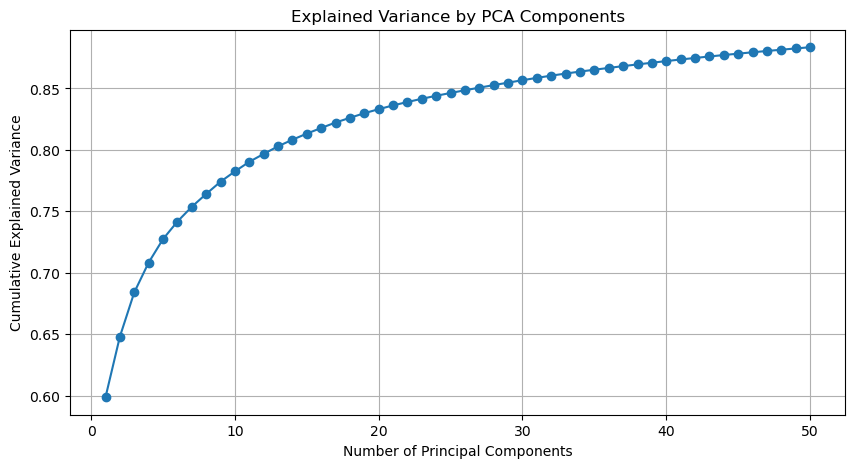

In [67]:
import matplotlib.pyplot as plt
import numpy as np

explained_variance_ratio = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid()
plt.show()


The first 50 components capture 85–87% of the variance.

In [68]:
X = df_features_subtitles.drop('averageRating_episode', axis=1)
y = df_features_subtitles['averageRating_episode']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

xgb_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

lgb_model = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 209723
[LightGBM] [Info] Number of data points in the train set: 27261, number of used features: 851
[LightGBM] [Info] Start training from score 7.641183


In [69]:
evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, xgb_pred, "XGBoost")
evaluate_model(y_test, lgb_pred, "LightGBM")



Random Forest Results:
RMSE: 0.4446
MAE: 0.3186
R2 Score: 0.6494
Accuracy (±0.5 points): 81.12%
Accuracy (±1.0 points): 96.10%

XGBoost Results:
RMSE: 0.4713
MAE: 0.3451
R2 Score: 0.6061
Accuracy (±0.5 points): 77.70%
Accuracy (±1.0 points): 95.79%

LightGBM Results:
RMSE: 0.4769
MAE: 0.3478
R2 Score: 0.5967
Accuracy (±0.5 points): 77.73%
Accuracy (±1.0 points): 95.69%


(0.47687704050969054,
 0.34783467976751353,
 0.5967036561334536,
 77.72887323943662,
 95.68661971830986)

###  Train an MLP (Deep Learning) Model

In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler  # Changed from MinMaxScaler

In [103]:
class MLPRegressor(nn.Module):
    def __init__(self, input_size):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Reduced size
        self.bn1 = nn.BatchNorm1d(256)  # Added batch normalization
        self.dropout1 = nn.Dropout(0.3)  # Added dropout
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.1)
        
        self.fc4 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.dropout1(self.bn1(torch.relu(self.fc1(x))))
        x = self.dropout2(self.bn2(torch.relu(self.fc2(x))))
        x = self.dropout3(self.bn3(torch.relu(self.fc3(x))))
        x = self.fc4(x)
        return x

In [104]:
# Data preprocessing
X = df_features_subtitles.drop('averageRating_episode', axis=1)
y = df_features_subtitles['averageRating_episode']

# Standardize features
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

# Scale target (but keep it simple)
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Smaller batch size

# Initialize model and training components
model = MLPRegressor(input_size=X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay
criterion = nn.MSELoss()  # Changed to MSE loss

In [105]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


In [106]:
# Training loop with early stopping
num_epochs = 200
best_val_loss = float('inf')
patience = 15
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Added gradient clipping
        optimizer.step()
        epoch_loss += loss.item()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        
    train_losses.append(epoch_loss / len(train_loader))
    val_losses.append(val_loss.item())
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break
        
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

# Load best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Make predictions
with torch.no_grad():
    predictions = model(X_test_tensor)
    # Inverse transform predictions and true values
    predictions = target_scaler.inverse_transform(predictions.numpy())
    y_test_original = target_scaler.inverse_transform(y_test)

Epoch 10, Train Loss: 0.3692, Val Loss: 0.4569
Epoch 20, Train Loss: 0.2935, Val Loss: 0.4334
Epoch 30, Train Loss: 0.2496, Val Loss: 0.4275
Epoch 40, Train Loss: 0.1978, Val Loss: 0.4192
Epoch 50, Train Loss: 0.1829, Val Loss: 0.4194
Early stopping triggered at epoch 58


/tmp/ipykernel_2224361/735236138.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [110]:
mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)
r2 = r2_score(y_test_original, predictions)

# Calculate accuracy for different error margins
def accuracy_within_range(y_true, y_pred, margin):
    within_range = np.abs(y_true - y_pred) <= margin
    return np.mean(within_range) * 100

acc_0_5 = accuracy_within_range(y_test_original, predictions, 0.5)  # Within 0.5 points
acc_1_0 = accuracy_within_range(y_test_original, predictions, 1.0)  # Within 1.0 points

print("MLP Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Accuracy (±0.5 points): {acc_0_5:.2f}%")
print(f"Accuracy (±1.0 points): {acc_1_0:.2f}%")

MLP Results:
RMSE: 0.4672
MAE: 0.3430
R2 Score: 0.6130
Accuracy (±0.5 points): 77.73%
Accuracy (±1.0 points): 95.82%


MLP doesn’t capture the patterns better than tree-based models.

### Extract More Features from Subtitles

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=500)  # Use top 500 words
tfidf_features = vectorizer.fit_transform(df_summarized_subtitles['full_summary'])

# Convert TF-IDF to DataFrame
df_tfidf = pd.DataFrame(tfidf_features.toarray(), columns=vectorizer.get_feature_names_out())

# Merge with features
df_features_text = pd.concat([df_summarized_subtitles[['sub_id']], df_tfidf], axis=1)
df_features_combined = df_features_subtitles.merge(df_features_text, on='sub_id', how='left')


In [113]:
!pip install textblob

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Loading egg at /sise/home/lielbin/.conda/envs/myenv/lib/python3.12/site-packages/huggingface_hub-0.27.0-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 2.6 MB/s eta 0:00:0000:0100:01


In [114]:
from textblob import TextBlob

df_summarized_subtitles['sentiment'] = df_summarized_subtitles['full_summary'].apply(lambda text: TextBlob(text).sentiment.polarity)
df_features_combined = df_features_combined.merge(df_summarized_subtitles[['sub_id', 'sentiment']], on='sub_id', how='left')


In [116]:
# Data preprocessing
X = df_features_combined.drop('averageRating_episode', axis=1)
y = df_features_combined['averageRating_episode']

# Standardize features
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

# Scale target (but keep it simple)
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Smaller batch size

# Initialize model and training components
model = MLPRegressor(input_size=X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay
criterion = nn.MSELoss()  # Changed to MSE loss

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)



In [117]:
# Training loop with early stopping
num_epochs = 200
best_val_loss = float('inf')
patience = 15
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Added gradient clipping
        optimizer.step()
        epoch_loss += loss.item()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        
    train_losses.append(epoch_loss / len(train_loader))
    val_losses.append(val_loss.item())
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break
        
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

# Load best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Make predictions
with torch.no_grad():
    predictions = model(X_test_tensor)
    # Inverse transform predictions and true values
    predictions = target_scaler.inverse_transform(predictions.numpy())
    y_test_original = target_scaler.inverse_transform(y_test)

Epoch 10, Train Loss: 0.3095, Val Loss: 0.4793
Epoch 20, Train Loss: 0.2268, Val Loss: 0.4649
Epoch 30, Train Loss: 0.1899, Val Loss: 0.4662
Epoch 40, Train Loss: 0.1493, Val Loss: 0.4484
Epoch 50, Train Loss: 0.1354, Val Loss: 0.4471
Epoch 60, Train Loss: 0.1257, Val Loss: 0.4395
Epoch 70, Train Loss: 0.1115, Val Loss: 0.4348
Epoch 80, Train Loss: 0.1033, Val Loss: 0.4465
Epoch 90, Train Loss: 0.1032, Val Loss: 0.4337
Epoch 100, Train Loss: 0.1016, Val Loss: 0.4352
Epoch 110, Train Loss: 0.1011, Val Loss: 0.4461
Early stopping triggered at epoch 116


/tmp/ipykernel_2224361/735236138.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [118]:
mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)
r2 = r2_score(y_test_original, predictions)

# Calculate accuracy for different error margins
def accuracy_within_range(y_true, y_pred, margin):
    within_range = np.abs(y_true - y_pred) <= margin
    return np.mean(within_range) * 100

acc_0_5 = accuracy_within_range(y_test_original, predictions, 0.5)  # Within 0.5 points
acc_1_0 = accuracy_within_range(y_test_original, predictions, 1.0)  # Within 1.0 points

print("MLP Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Accuracy (±0.5 points): {acc_0_5:.2f}%")
print(f"Accuracy (±1.0 points): {acc_1_0:.2f}%")

MLP Results:
RMSE: 0.4802
MAE: 0.3564
R2 Score: 0.5548
Accuracy (±0.5 points): 75.62%
Accuracy (±1.0 points): 95.21%


#### Hybrid Model (Combine MLP + Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)


/home/lielbin/.conda/envs/myenv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
final_prediction = (0.6 * rf_pred) + (0.4 * mlp_pred_original)  # Adjust weights
evaluate_model(y_test, final_prediction, "Hybrid Model (RF + MLP)")
